In [3]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import signal
import mrcfile as mrc
from scipy import stats
from sklearn.mixture import GaussianMixture as GM
from scipy.stats import norm

In [2]:
npix = 64

## Functions for plotting summary statistics

In [2]:
def read_mrc(filename):
    read_data = mrc.open(filename, mode = "r+")
    data_mat = read_data.data
    return data_mat

def plot_single_particle_marginal(data, ax):
    ax.set_title('Single Particle Marginal')
    ax.set_xlabel('intensity',fontsize = 15)
    ax.set_ylabel('count', fontsize = 15)
    xs = np.arange(-10,10,0.001)

    data_flat = data.ravel()
    mu = np.mean(data_flat)
    sigma = np.std(data_flat)
    
    pdf1 = norm.pdf(xs, mu, sigma)

    ax.plot(xs, pdf1, label = 'Gaussian\n $\mu$ = 1, $\sigma$ = 1' )
    ax.hist(data.ravel(), bins = 1000, density = True, label = 'data', range = [-10,10])
    ax.legend(loc='upper left')
    
    return ax

def statistics(data, distrib_guess):
    skew = stats.skew(data)
    ks, pval = stats.kstest(data, str(distrib_guess))
    return skew, ks, pval

def Gaussian_fit(data, comp_numb):
    mrc_gm = mrc_flat.reshape(-1,1)
    gm = GM(n_components = comp_numb)  #import Gaussian_Mixture as GM
    model = gm.fit(mrc_gm)
    mu_list = model.means_.flatten()
    sigma_list = np.sqrt(model.covariances_.flatten())
    return mu_list, sigma_list

def get_avg_corr(data):
    corr_list = []
    for i in range(len(data)):
        corr = signal.correlate2d(data[i], data[i], boundary='wrap', mode='same')
        corr_list.append(corr)
    avg_corr = np.mean(corr_list, axis=0)
    return avg_corr


def plot_empirical_covariance(avg_corr, ax, filename):
    log_avg_corr = np.log(np.abs(avg_corr))
    ax.set_title('2d Correlation Function of' + str(filename))
    hm = ax.pcolor(log_avg_corr)
    plt.colorbar(hm, ax=ax)
    return ax

def plot_slices(avg_corr, ax, npix=64):
    slice_corr_x = np.copy(avg_corr[:, npix//2-1]) # x and y might be messed up here.
    slice_corr_y = np.copy(avg_corr[npix//2-1, :])
    
    slice_corr_x -= np.min(slice_corr_x)
    slice_corr_x /= np.max(slice_corr_x)
    
    slice_corr_y -= np.min(slice_corr_y)
    slice_corr_y /= np.max(slice_corr_y)
    
    xs = np.arange(-npix//2+1,npix//2+1,1)
    print(slice_corr_x.shape, xs.shape)
    ax.plot(xs, slice_corr_x, label="slice 1")
    ax.plot(xs, slice_corr_y, label="slice 2")
    ax.plot(xs, np.exp(-np.abs(xs)), linestyle=':', label='reference')
    ax.legend()
    ax.set_title("Corr Fxn slices")
    return ax
#     ax.plot()
    

def plot_summary_statistics(data, cov=None, npix=64):
    fig, axes = plt.subplots(1, 3, figsize=(11, 3))
    plt.tight_layout()
    plot_single_particle_marginal(data, axes[0])
    
    avg_corr = get_avg_corr(data)
    plot_empirical_covariance(avg_corr, axes[1])
    plot_slices(avg_corr, axes[2])

## Naive, exponential correlation.

In [4]:
def naive_exp_generation(num_images, npix=64):
    ### Correlated
    data_mu = np.ones(npix * npix)
    # data_sigma = np.eye(128)
    t = time()
    X, Y = np.meshgrid(np.arange(npix), np.arange(npix))
    X_flat = X.ravel()
    Y_flat = Y.ravel()
    dX = X_flat - X_flat.reshape(-1,1)
    dY = Y_flat - Y_flat.reshape(-1,1)
    K =  np.exp(-np.sqrt(dX**2 + dY**2 ))
    print("Setup time: ", time() - t)
    # data_sigma
    # mrc_data = np.r

    mrc_data = np.random.multivariate_normal(data_mu, K, size=num_images).reshape(num_images, npix, npix)
    print("Total time: ", time() - t)
    return mrc_data

In [5]:
for i in [1,10,100]:
    print("------------ t=", i)
    noise_naive = naive_exp_generation(i, npix)
    

------------ t= 1
Setup time:  0.2984638214111328
Total time:  17.09406590461731
------------ t= 10
Setup time:  0.2931215763092041
Total time:  17.39898157119751
------------ t= 100
Setup time:  0.3137171268463135
Total time:  17.63797402381897


(64,) (64,)


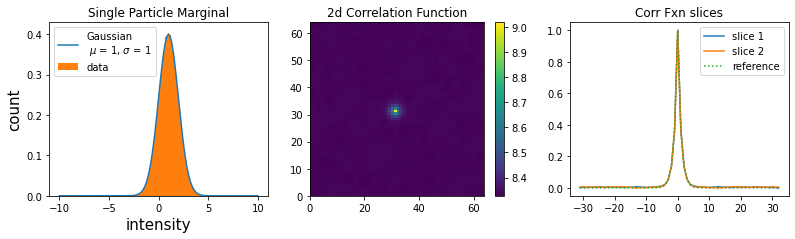

In [19]:
plot_summary_statistics(noise_naive)

## Generation by Manually taking the Cholesky

In [7]:
def generate_cholesky_factor():
    X, Y = np.meshgrid(np.arange(npix), np.arange(npix))
    X_flat = X.ravel()
    Y_flat = Y.ravel()
    dX = X_flat - X_flat.reshape(-1,1)
    dY = Y_flat - Y_flat.reshape(-1,1)
    K =  np.exp(-np.sqrt(dX**2 + dY**2 ))
    L = np.linalg.cholesky(K)
    return L

def noise_from_sq_root(num_images, mu, L, npix=64):
    ### Correlated
    # data_sigma = np.eye(128)
    mrc_data = np.random.randn(num_images * npix * npix).reshape(num_images, npix * npix)
    mrc_data  = mrc_data @ L + mu
    return mrc_data.reshape(num_images, npix, npix)

def manual_exp_generation(num_images, npix=64):
    t = time()
    L = generate_cholesky_factor()
    data_mu = np.ones(npix * npix)
    print("made factors:", time() - t)
    mrc_data = noise_from_sq_root(num_images, data_mu, L, npix)
    print("made noise", time() - t)
    return mrc_data
    
L = generate_cholesky_factor()

In [8]:
for i in [1, 10,100]:
    print("------------ t=", i)
    man_noise = manual_exp_generation(i, npix)

------------ t= 1
made factors: 0.7696554660797119
made noise 0.7784626483917236
------------ t= 10
made factors: 0.7897539138793945
made noise 0.8034791946411133
------------ t= 100
made factors: 0.7684824466705322
made noise 0.8060698509216309


(64,) (64,)


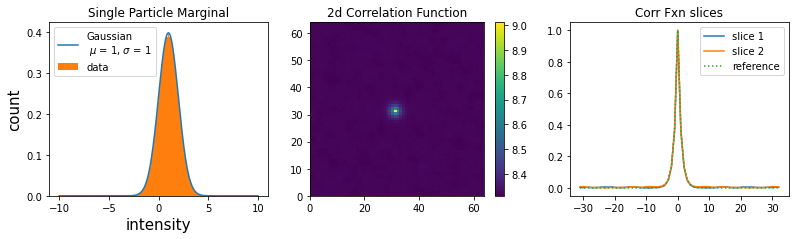

In [20]:
plot_summary_statistics(man_noise)